786


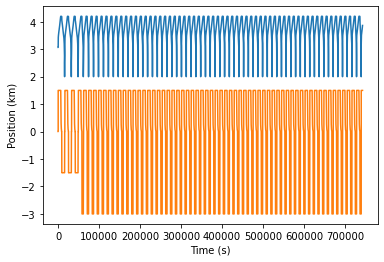

In [267]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from scipy import signal, misc


df = pd.read_csv ('SNL_18650_NMC_25C_0-100_0.5-1C_b_timeseries.csv')
# print(df)

tmp_arr = df[["Test_Time (s)", "Current (A)", "Voltage (V)"]].to_numpy()
time_v = tmp_arr[:,0]
currents = tmp_arr[:,1]
volts = tmp_arr[:,2]
#print(time_v)
#print(currents)
#print(volts)

plt.plot(time_v[1:10000], volts[1:10000])
plt.xlabel('Time (s)')
plt.ylabel('Position (km)')

plt.plot(time_v[1:10000], currents[1:10000])
plt.xlabel('Time (s)')
plt.ylabel('Position (km)')

test_volts = -volts
#test_volts = test_volts[test_volts > -3.1]
                      

#print(test_volts[1])    

#get the min values: newpks at newlocs, use the find peaks and take negative to get valleys
    
peaks = signal.find_peaks(test_volts, height= -3.1, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=None, plateau_size=None)
#peaks_ind = np.argwhere(peaks[0] > -3.1)
new_locs = peaks[0]
#ind_loc = ind_loc[peaks_ind]

# print(peaks[0])
#x=np.asarray(peaks[0], dtype = tuple)
#inds = x
#print(x)
#x.shape
#x = x.astype(int)

# tt = np.array([1345, 23420, 21, 3420])
time_locs= time_v[new_locs]
len_mins = time_locs.shape[0]

time_gaps = np.zeros(len_mins)
ind_gaps = np.zeros(len_mins) 

time_gaps[0] = time_locs[0]
ind_gaps[0] = new_locs[0] 


for i in range(1, len_mins):
    time_gaps[i] = time_locs[i]- time_locs[i-1]  
    ind_gaps[i]= new_locs[i]- new_locs[i-1]


print(len(ind_gaps))
#print(ind_gaps[521])
#print(len_mins)


In [268]:
ind_gaps = ind_gaps.astype(int)   
cap_counter = int(1)
cap_test = np.zeros(volts.size)
    
    
#we want to start isolateing the capacitance test/check cycles from other cycles
#One identifying portion will be the max current during a cycle we store this value 
# in ' avgMaxCur'. We then set a trigger based on the average max current
# value. The capacitance check/test cycles should have lower than average
# currents.
    
    
avgMaxCur =np.zeros(len_mins)


for j in range(0, len_mins):
       tmp_v= volts[cap_counter: (cap_counter + ind_gaps[j].astype(int))];
       i = np.argmax(tmp_v)
       tmp_c= currents[(cap_counter + i): (cap_counter + ind_gaps[j].astype(int))];
       tmp_c_abs = np.absolute(tmp_c)
       b = np.amax(tmp_c_abs);
       avgMaxCur[j] = b
       cap_counter = cap_counter + ind_gaps[j];  


avg_Cur = sum(avgMaxCur)/(len(time_gaps));
triger= np.mean(avgMaxCur)*0.6 

#count how many tests are cap checks in 'num_test' . We assume all are
#then subtract if it fails trigger.


num_tests = len(time_gaps);
cap_counter = 1;
wher_cap = np.ones(len(ind_gaps)); # i want a np array the size of ind_gaps with all 1s?
for j in range (0, len(time_gaps)-1):
    if avgMaxCur[j]> (triger) :
        num_tests = num_tests-1;
        wher_cap[j]= 0;
 
 # Now we engineer for common corner cases. Some data files have all test
# cycles so we say if we find fewer than 6 test cycles. then all of them
# must be test cycles.
 
if(num_tests >6):
    test_cyclestemp = np.where(wher_cap == 1);  # return the indices of non zero elements in array "wher_cap"?
    not_testcycles = np.where(wher_cap== 0);  # return the indices of zero elements?
 
 
if(num_tests<=6):
    test_cycles = list(range(1, len(avgMaxCur)))   # create an array test_cycles that counts up to length of avgMaxcur ie [1 2 3...length(avgMaxCur)]
    not_testcycles = np.zeros(len(avgMaxCur))
    triger = 1.1*max(avgMaxCur);
    num_tests = len(avgMaxCur);
    
# identify and store the cap checks/test cycles in a matrix
 
cap_test_mat = np.zeros((num_tests, max(ind_gaps),4)); 

print(cap_test_mat.shape)
# I want a 3d matrix that has num_test number of rows, Max(ind_gaps) columns, and has 3 width(z-direction)
num_test_count= 0;
 
# grab the voltages that are the cap tests
# create the matrix with the cap tests

cap_counter = 1;
     
#print(ind_gaps)
      
for j in range (0,  len(time_gaps)):
    #print("j=" + str(j)+ " avgMaxCur = " + str(avgMaxCur[j])+ "triger =" + str(triger))
    if avgMaxCur[j] < (triger):
       
        cap_test[cap_counter: (cap_counter + ind_gaps[j]-1)]= volts[cap_counter: (cap_counter + ind_gaps[j]-1)];
        #num_test_count= num_test_count+1;
        #if (j == 521):
            #print("num_test_count")
            #print(num_test_count)
            #print("voltage values")
            #print(cap_counter)
            #print((cap_counter + ind_gaps[j]-1))
        
        cap_test_mat[num_test_count,1:ind_gaps[j],1]= volts[cap_counter: (cap_counter + ind_gaps[j]-1)];
        cap_test_mat[num_test_count,1, 2] = cap_counter;
        cap_test_mat[num_test_count,1, 3] = cap_counter + ind_gaps[j]-1;
        num_test_count= num_test_count+1;
        #print("capcount=" +str(cap_counter))
        #print("ind_gaps=" +str(ind_gaps[j]))
        #print("captestmat=" +str(cap_test_mat[num_test_count,1, 2]))
      
    cap_counter = cap_counter + ind_gaps[j];  #ticking through the array
      
      
      
#so now all the cap test/check cycles are stored in a mat 'cap_test_mat'
test_cyclesfin =  test_cyclestemp[0]
print(len(test_cyclesfin))
print(triger)
print(test_cyclesfin)
print(len(avgMaxCur))

(32, 1483, 4)
32
1.761667175572519
[  0   1   2 253 254 255 256 257 258 385 386 387 388 389 390 391 518 519
 520 521 522 523 524 651 652 653 654 655 656 783 784 785]
786


Text(0, 0.5, 'voltage')

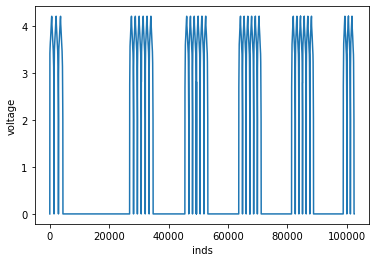

In [269]:
plt.plot(cap_test)
plt.xlabel('inds')
plt.ylabel('voltage')
#print(num_test_count)
#print(len(test_cyclesfin))
#print(cap_test_mat[19,:,1])
#print(triger)
#print(avgMaxCur[521])
#print(len(time_gaps))
#print(volts[65733])
#print(ind_gaps[521])



In [270]:
#print(num_tests)
#print(num_test_count)


In [271]:
 #discharge matrix
 # create two matrix from the test cap mat matrix that holds the
 # discharge discharge portion of the cycle. one mat for voltage one for
 # current. We start by identifing the maximum voltage value of the cycle
 # and then we determine where the discharge beggins with the current and
 # volage gradient
 len_discharge = np.amax(ind_gaps);
 gradien =1
 dis_mat_v = np.zeros((num_tests, len_discharge,6));
 dis_mat_currents = np.zeros((num_tests, max(ind_gaps),6));
 for x in range (0, num_test_count):
     temp = volts[cap_test_mat[x,1,2].astype(int):cap_test_mat[x,1,3].astype(int)]; 
     I = np.argmax(temp)
     flager1=0;
     t = 0;
     temp_curnt = 1;
     diff_temp = np.diff(temp);
     while t < (len(temp)- I-2) and (temp_curnt >= 0  or gradien >= 0):
         t=t+1;
         gradien= diff_temp[I+t];
         temp_curnt = currents[cap_test_mat[x,1,2].astype(int) +I+t];
     
     I = I +t;
         
     temp_new = temp[I:len(temp)];
     dis_mat_v[x, 1:len(temp_new)+1,1] = temp_new;
     dis_mat_v[x,1,2] = I ;
     dis_mat_v[x,1,3] = len(temp_new);
     dis_mat_v[x,1,4] = cap_test_mat[x,1,2] + I;
     dis_mat_v[x,1,5] = cap_test_mat[x,1,3];
      
     
     dis_mat_currents[x, 1:(dis_mat_v[x,1,5].astype(int)-dis_mat_v[x,1,4].astype(int)+1),1] = currents[dis_mat_v[x,1,4].astype(int):dis_mat_v[x,1,5].astype(int)];
     dis_mat_currents[x,1,2] =dis_mat_v[x,1,2]; # where does discharge start in temp
     dis_mat_currents[x,1,3] = dis_mat_v[x,1,3]; # where does it end in temp
     dis_mat_currents[x,1,4] =dis_mat_v[x,1,4];
     dis_mat_currents[x,1,5] = dis_mat_v[x,1,5];
print(num_tests)
     


32


In [272]:
print(x)
print(len(diff_temp))
print(I)
print(len(temp))
poo = cap_test_mat[x,1,3]-cap_test_mat[x,1,2]
print(poo)
print(I+t)
print(t)


31
1192
552
1193
1193.0
592
40


Text(0, 0.5, 'voltage')

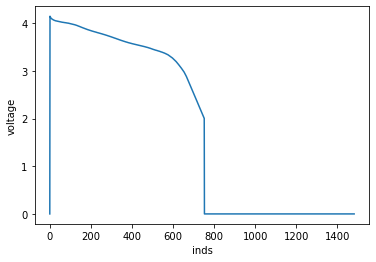

In [273]:
plt.plot(dis_mat_v[1,:,1])
plt.xlabel('inds')
plt.ylabel('voltage')





In [274]:
# sort out 

# At this point we have sorted out the cap checks from the other cycles
# only by current values stored them in cap_test_mat and then created a matrix for the discharges 
# in dis_mat_(cur/volt). However it turns out that a single variable doesnt discriminate  well in
# all cases. So some of our identified cap checks are actually just normal cycles!  We must sort
# them out. We use another important factor for discriminating: length of
# discharge. IF the discharge is longer than a trigger (weighted avg and
# std) then we keep it as a cap test cycle. if not we discard that cycle.
# We go back through the cap_test_mat dis_mat(cur/volt) and get rid of the
# bad cycles

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

length_dis = np.zeros(num_test_count);
length_char = np.zeros(num_test_count);
for i in range (0, num_test_count):
      length_dis[i] = time_v[dis_mat_currents[i,1,5].astype(int)] - time_v[dis_mat_currents[i,1,4].astype(int)];
      length_char[i]= dis_mat_currents[i,1,2] ;
  
      
avg_dis_len = np.mean(length_dis);
find_right_cycles = np.where(length_dis > ((0.5* avg_dis_len )+ np.std(length_dis)))[0]
find_right_cycles_2 = np.where(length_char > (0.5*np.mean(length_char)))[0]

#print(find_right_cycles)
#print(find_right_cycles_2)

find_right_cycles_3= intersection(find_right_cycles, find_right_cycles_2)
find_right_cycles_4 = np.asarray(find_right_cycles_3)

#print (find_right_cycles_3)
#print (len(find_right_cycles_4.astype(int)))

test_cycles = np.array(test_cyclesfin)[find_right_cycles_4.astype(int)];
num_cycles = len(find_right_cycles_4.astype(int))


find_notcyc = np.ones(len(time_gaps));
find_notcyc[test_cycles] = 0;
not_test_cycles = np.where(find_notcyc == 1);
num_notcycles = len(not_test_cycles);

new_captest_mat= cap_test_mat[find_right_cycles_4.astype(int),:,:];
new_discharge_c = dis_mat_currents[find_right_cycles_4.astype(int),:,:]; 
new_discharge_v = dis_mat_v[find_right_cycles_4.astype(int),:,:]; 
     
dis_mat_currents = new_discharge_c;
cap_test_mat =new_captest_mat;
dis_mat_v =new_discharge_v;
num_tests= len(dis_mat_v[:,1,1]);
print(test_cycles)
print(dis_mat_v[:,1,2])


[  0   1   2 253 254 255 256 257 258 385 386 387 389 390 391 518 519 520
 522 523 524 651 652 653 654 655 656 783 784 785]
[679. 730. 728. 647. 613. 615. 666. 622. 621. 637. 597. 598. 566. 604.
 603. 615. 575. 577. 568. 588. 587. 603. 567. 568. 596. 565. 564. 586.
 551. 552.]


In [275]:
# get the not cap checks
# now we store the not cap check cycles or 'normal cycles' into a matrix.
# we will need them later when we again construct discharge and charge
# mats for both voltage and current. 
# we exclud certain bad cycles. These are either fake cycles from a bad
# tester or falsly identified cycles.

Notcap_test_mat = np.zeros((len(time_gaps), np.amax(ind_gaps),4))
     # grab the voltages that are the cap tests
     # create the matrix with the cap tests
Ncap_counter = 1;
Notnum_test_count=0;
                           
for j in range(0, len(ind_gaps)-1):
        
        Notcap_test_mat[Notnum_test_count,1:ind_gaps[j],1]= volts[Ncap_counter: (Ncap_counter + ind_gaps[j]-1)];
        Notcap_test_mat[Notnum_test_count,1, 2] = Ncap_counter;
        Notcap_test_mat[Notnum_test_count,1, 3] = Ncap_counter + ind_gaps[j]-1;
        Notnum_test_count= Notnum_test_count + 1;                 
        Ncap_counter = Ncap_counter + ind_gaps[j];  #ticking through the array


not_cap_test_mat1 = Notcap_test_mat[not_test_cycles, :,:];
not_cap_test_mat = not_cap_test_mat1[0]

cur_check = np.zeros(len(not_cap_test_mat[:,1,1]))
count_nzero=0;
for k in range (0, len(not_cap_test_mat[:,1,1])-1):
     zero_check = currents[not_cap_test_mat[k,1,2].astype(int):not_cap_test_mat[k,1,3].astype(int)];
     if np.amax(zero_check) >0 :
        cur_check[k] = 1;
        count_nzero = count_nzero+1;
     


opp_cur_check3 = np.where(cur_check ==0);
opp_cur_check2= np.asarray(opp_cur_check3)
opp_cur_check = opp_cur_check2[0]



bad_cycles = not_test_cycles[0][opp_cur_check];


cur_check3 = np.where(cur_check==1);
cur_check2 = np.asarray(cur_check3)
cur_check1 = cur_check3[0]

TEMP_NCAP = not_cap_test_mat[cur_check1.astype(int), :,:];
not_cap_test_mat = TEMP_NCAP;
not_test_cycles = not_test_cycles[0][cur_check1];

In [276]:
print(num_cycles)
print(num_tests)
print(len(not_test_cycles))


30
30
753


In [277]:
#trim the not test cycles

# some cycles beggin with a rest (all values =0). We want to cut these
# breaks out.

r= 1;

while r < len(not_cap_test_mat[:,1,1]):
    #print("im here")
    #p =len(currents[not_cap_test_mat[r,1,2].astype(int):not_cap_test_mat[r,1,3]].astype(int))
    #temp_trim = np.zeros(len(currents[not_cap_test_mat[r,1,2].astype(int):not_cap_test_mat[r,1,3]].astype(int)))
    
    temp_trim = currents[not_cap_test_mat[r,1,2].astype(int):not_cap_test_mat[r,1,3].astype(int)];
    finder_a = np.where(temp_trim > 0);
    finder_a = np.amin(finder_a);
    p =len(temp_trim)
    tmpp_1 = temp_trim[finder_a : p];
    not_cap_test_mat[r, :,1] = 0;
    not_cap_test_mat[r,1:(len(temp_trim)-(finder_a-1)),1] = tmpp_1;
    not_cap_test_mat[r,1,2] = finder_a + not_cap_test_mat[r,1,2];
    r=r+1;

#check
 



In [278]:
#get the not cycles charge 
# in the same way that we did earlier we construct charge mat for the not
# test cycles denoted Nchar_mat(v/currents)
# in the charge cycles we denote Cv portions and CC portions
# not there are some correctional factors as the value1 in our matlab var
# volts is actually value 2 in the original excell file. this causes
# confusion. 



Nchar_mat_v = np.zeros((len(not_test_cycles), np.amax(ind_gaps),6));
Nchar_mat_currents = np.zeros((len(not_test_cycles), np.amax(ind_gaps),6));
counter =0;


for x in range (0, len(not_test_cycles)):
    counter = counter +1;
    
    temp = volts[not_cap_test_mat[x,1,2].astype(int) : not_cap_test_mat[x,1,3].astype(int)]; 
    M = np.max(temp);
    I = np.argmax(temp)
    cc_charI = np.ceil(I/2);
    I = cc_charI;
    flager1=0;
    t = 1;
    temp_curnt = 1;
    diff_temp = np.diff(temp);
    while t < (len(temp)- I-1) and (temp_curnt > 0.001):
        t=t+1;
        gradien= diff_temp[(I+t).astype(int)];
        temp_curnt = currents[not_cap_test_mat[x,1,2].astype(int)+(I+t).astype(int)];
    
    I = I +t-1;
     
    cur_tem= currents[(not_cap_test_mat[x,1,2].astype(int)+ 3): (not_cap_test_mat[x,1,2].astype(int) +I.astype(int)-3)];
    vol_tem =volts[(not_cap_test_mat[x,1,2].astype(int)+ 3): (not_cap_test_mat[x,1,2].astype(int) +I.astype(int) -2)];
    # not that there is a +3 that needs to be corrected for between
    # cur_temp and currents same for vol_temp and volts

        # we use medfilt1 and smooth the voltage values then determine when
        # there is a voltage gradient near 0 so that its CV
    vol_tem1 = signal.medfilt(vol_tem,15);
    vol_temdiff = (np.diff(vol_tem1));
    minmus = np.where(vol_temdiff ==0);
                                                              
                                                       
    
    cc = np.amin(minmus)+2; # note the +2 correction 
         
         # here we are engineering a soln for a common edge case where
         # there is a slight delay in when the voltage gradient goes to 0.
    if (cur_tem[cc-2] < 0.95* np.amax(cur_tem)):
        cc = cc-1;
             
     
    temp_new = temp[1:I.astype(int)];
    Nchar_mat_v[x, 0:len(temp_new),1] = temp_new;
    Nchar_mat_v[x,1,2] = I.astype(int);
    Nchar_mat_v[x,1,3] = 1;
    #if len(cc) >0: 
    #    Nchar_mat_v[x,1,3] = cc ;
    
    Nchar_mat_v[x,1,4] = not_cap_test_mat[x,1,2];
    Nchar_mat_v[x,1,5] = not_cap_test_mat[x,1,2] +I.astype(int);
      
    Nchar_mat_currents[x, 1:(Nchar_mat_v[x,1,5].astype(int)-Nchar_mat_v[x,1,4].astype(int)+1),1] = currents[Nchar_mat_v[x,1,4].astype(int):Nchar_mat_v[x,1,5].astype(int)];
    Nchar_mat_currents[x,1,2]=Nchar_mat_v[x,1,2]; # where does discharge start in temp
    Nchar_mat_currents[x,1,3] = Nchar_mat_v[x,1,3]; # where does it end in temp
    Nchar_mat_currents[x,1,4] =Nchar_mat_v[x,1,4];
    Nchar_mat_currents[x,1,5] = Nchar_mat_v[x,1,5];
     



Text(0, 0.5, 'voltage')

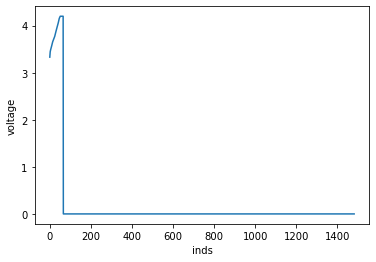

In [279]:
plt.plot(Nchar_mat_v[1, : ,1])
plt.xlabel('inds')
plt.ylabel('voltage')
#print(num_test_count)


30


Text(0, 0.5, 'voltage')

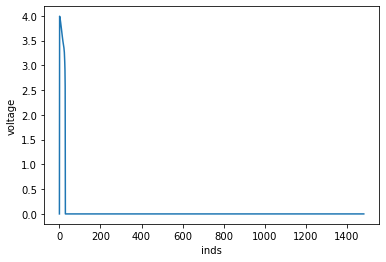

In [280]:
# 'Not discharge mat' = discharge mat for non capacitance check cycles

 
Ndis_mat_v = np.zeros((len(not_test_cycles), len_discharge,6));
Ndis_mat_currents = np.zeros((len(not_test_cycles), max(ind_gaps),6));
for x in range (0, len(not_test_cycles)):
     temp = volts[not_cap_test_mat[x,1,2].astype(int):not_cap_test_mat[x,1,3].astype(int)]; 
     I = np.argmax(temp)
     flager1=0;
     t = 0;
     temp_curnt = 1;
     diff_temp = np.diff(temp);
     while t < (len(temp)- I-2) and (temp_curnt >= 0  or gradien >= 0):
         t=t+1;
         gradien= diff_temp[I+t];
         temp_curnt = currents[not_cap_test_mat[x,1,2].astype(int) +I+t];
     
     I = I +t;
         
     temp_new = temp[I:len(temp)];
     Ndis_mat_v[x, 1:len(temp_new)+1,1] = temp_new;
     Ndis_mat_v[x,1,2] = I ;
     Ndis_mat_v[x,1,3] = len(temp_new);
     Ndis_mat_v[x,1,4] = not_cap_test_mat[x,1,2] + I;
     Ndis_mat_v[x,1,5] = not_cap_test_mat[x,1,3];
      
     
     Ndis_mat_currents[x, 1:(Ndis_mat_v[x,1,5].astype(int)-Ndis_mat_v[x,1,4].astype(int)+1),1] = currents[Ndis_mat_v[x,1,4].astype(int):Ndis_mat_v[x,1,5].astype(int)];
     Ndis_mat_currents[x,1,2] =Ndis_mat_v[x,1,2]; # where does discharge start in temp
     Ndis_mat_currents[x,1,3] = Ndis_mat_v[x,1,3]; # where does it end in temp
     Ndis_mat_currents[x,1,4] =Ndis_mat_v[x,1,4];
     Ndis_mat_currents[x,1,5] = Ndis_mat_v[x,1,5];
print(num_tests)

plt.plot(Ndis_mat_v[2, : ,1])
plt.xlabel('inds')
plt.ylabel('voltage')
#print(num_test_count)
     

Text(0, 0.5, 'voltage')

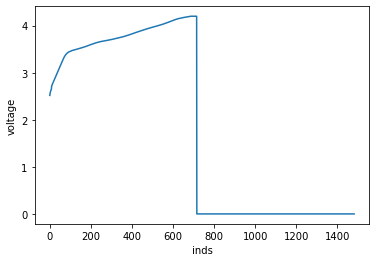

In [281]:
#charge matrix for the capacitance check cycle


char_mat_v = np.zeros((len(not_test_cycles), np.amax(ind_gaps),6));
char_mat_currents = np.zeros((len(not_test_cycles), np.amax(ind_gaps),6));


for x in range (0, len(test_cycles)):
    counter = counter +1;
    
    temp = volts[cap_test_mat[x,1,2].astype(int) : cap_test_mat[x,1,3].astype(int)]; 
    M = np.max(temp);
    I = np.argmax(temp)
    cc_charI = np.ceil(I/2);
    I = cc_charI;
    flager1=0;
    t = 1;
    temp_curnt = 1;
    diff_temp = np.diff(temp);
    while t < (len(temp)- I-1) and (temp_curnt > 0.001):
        t=t+1;
        gradien= diff_temp[(I+t).astype(int)];
        temp_curnt = currents[cap_test_mat[x,1,2].astype(int)+(I+t).astype(int)];
    
    I = I +t-1;
     
    cur_tem= currents[(cap_test_mat[x,1,2].astype(int)+ 3): (cap_test_mat[x,1,2].astype(int) +I.astype(int)-3)];
    vol_tem =volts[(cap_test_mat[x,1,2].astype(int)+ 3): (cap_test_mat[x,1,2].astype(int) +I.astype(int) -2)];
    # not that there is a +3 that needs to be corrected for between
    # cur_temp and currents same for vol_temp and volts

        # we use medfilt1 and smooth the voltage values then determine when
        # there is a voltage gradient near 0 so that its CV
    vol_tem1 = signal.medfilt(vol_tem,15);
    vol_temdiff = (np.diff(vol_tem1));
    minmus = np.where(vol_temdiff ==0);
                                                              
                                                       
    
    cc = np.amin(minmus)+2; # note the +2 correction 
         
         # here we are engineering a soln for a common edge case where
         # there is a slight delay in when the voltage gradient goes to 0.
    if (cur_tem[cc-2] < 0.95* np.amax(cur_tem)):
        cc = cc-1;
             
     
    temp_new = temp[1:I.astype(int)];
    char_mat_v[x, 0:len(temp_new),1] = temp_new;
    char_mat_v[x,1,2] = I.astype(int);
    char_mat_v[x,1,3] = 1;
    #if len(cc) >0: 
    #    Nchar_mat_v[x,1,3] = cc ;
    
    char_mat_v[x,1,4] = cap_test_mat[x,1,2];
    char_mat_v[x,1,5] = cap_test_mat[x,1,2] +I.astype(int);
      
    char_mat_currents[x, 1:(char_mat_v[x,1,5].astype(int)-char_mat_v[x,1,4].astype(int)+1),1] = currents[char_mat_v[x,1,4].astype(int):char_mat_v[x,1,5].astype(int)];
    char_mat_currents[x,1,2]=char_mat_v[x,1,2]; # where does discharge start in temp
    char_mat_currents[x,1,3] = char_mat_v[x,1,3]; # where does it end in temp
    char_mat_currents[x,1,4] =char_mat_v[x,1,4];
    char_mat_currents[x,1,5] = char_mat_v[x,1,5];
     
plt.plot(char_mat_v[2, : ,1])
plt.xlabel('inds')
plt.ylabel('voltage')
#print(num_test_count)

In [282]:
#Compute Discharge Capacity
#Here we put everything togeather and get the discharge and charge
#capacity we also do the cc times
num_Ncyc = len(not_test_cycles)+1
dis_cap = np.zeros((num_cycles+1));
time_d = np.zeros((num_Ncyc));
   
Ntime_d = np.zeros((num_Ncyc));
Ntime_c= np.zeros((num_Ncyc));
Ntime_cv_char = np.zeros((num_Ncyc));
   
   
for i in range (0, num_Ncyc-1):
       time_tmp = time_v[Ndis_mat_currents[i,1,4].astype(int): Ndis_mat_currents[i,1,5].astype(int)];
       length_dis_tmp= Ndis_mat_currents[i,1,5].astype(int)- Ndis_mat_currents[i,1,4].astype(int)+1;
       Ntime_d[i] = time_v[Ndis_mat_currents[i,1,5].astype(int)] - time_v[Ndis_mat_currents[i,1,4].astype(int)]
       Ntime_c[i] = time_v[Nchar_mat_currents[i,1,5].astype(int)] - time_v[Nchar_mat_currents[i,1,4].astype(int)];
       Ntime_cv_char[i] = time_v[Nchar_mat_currents[i,1,5].astype(int)] - time_v[Nchar_mat_currents[i,1,4].astype(int)+ Nchar_mat_currents[i,1,3].astype(int)];    
   
   # above we calc the  cv charge time and the cc time is computed outside
   # the function 
  
   # below we do a numerical integration to get the discharge capacity
   
for i in range (0, num_cycles):
       time_tmp = time_v[dis_mat_currents[i,1,4].astype(int): dis_mat_currents[i,1,5].astype(int)];
       length_dis_tmp= dis_mat_currents[i,1,5].astype(int) -dis_mat_currents[i,1,4].astype(int)+1;
       dis_cap[i] = np.trapz(dis_mat_currents[i,1:length_dis_tmp,1],time_tmp);
       time_d[i] = time_v[dis_mat_currents[i,1,5].astype(int)] - time_v[dis_mat_currents[i,1,4].astype(int)];
   
  
dis_cap= -dis_cap;
dis_cap= dis_cap/3600;
debugg =dis_cap;
   
   
#now we calc the charge capacity in a simular way.
char_cap = np.zeros(num_cycles);
time_c = np.zeros(num_cycles);
time_cv_char= np.zeros(num_cycles);
for i in range(0,num_cycles):
    time_sc = time_v[char_mat_currents[i,1,4].astype(int): char_mat_currents[i,1,5].astype(int)];
    length_dis_tmp= char_mat_currents[i,1,5].astype(int)-char_mat_currents[i,1,4].astype(int)+1;
    char_cap[i] = np.trapz( char_mat_currents[i,1:length_dis_tmp,1],time_sc);
    time_c[i] = time_v[char_mat_currents[i,1,5].astype(int)]- time_v[char_mat_currents[i,1,4].astype(int)];
    time_cv_char[i] = time_v[char_mat_currents[i,1,5].astype(int)] - time_v[char_mat_currents[i,1,4].astype(int)+char_mat_currents[i,1,3].astype(int)];
   
char_cap= char_cap/3600;
   
  

Text(0, 0.5, 'voltage')

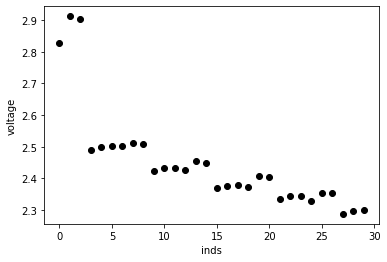

In [283]:
plt.plot(char_cap,'o', color='black')
plt.xlabel('inds')
plt.ylabel('voltage')
#print(num_test_count)
   

Text(0, 0.5, 'voltage')

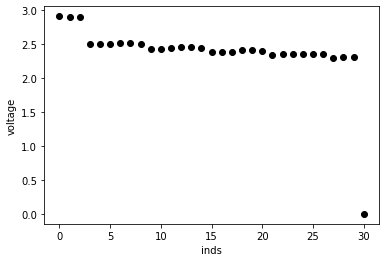

In [284]:
plt.plot( dis_cap, 'o', color='black')

plt.xlabel('inds')
plt.ylabel('voltage')
#print(num_test_count)


In [285]:
#really important final correction for the oxford set.
# representation of cycles is only the cycles and no other ones so we need
# to include a correction

if len(Ntime_d) ==0 and len(Ntime_c) ==0: 
    Ntime_d = 1;
    Ntime_c =1;
    Ntime_cv_char = 1;
    test_cycles= test_cycles*100;